In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_validate
from plotnine import ggplot, aes, geom_bar, labs, theme, element_text
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve, auc, make_scorer, recall_score, precision_score, cohen_kappa_score

In [2]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")

In [3]:
ha.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1
1,37,1,2,130,250,1,187,1
2,56,1,1,120,236,1,178,1
3,57,0,0,120,354,1,163,1
4,57,1,0,140,192,1,148,1


In [4]:
ha.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   age      273 non-null    int64
 1   sex      273 non-null    int64
 2   cp       273 non-null    int64
 3   trtbps   273 non-null    int64
 4   chol     273 non-null    int64
 5   restecg  273 non-null    int64
 6   thalach  273 non-null    int64
 7   output   273 non-null    int64
dtypes: int64(8)
memory usage: 17.2 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   age      273 non-null    int64
 1   sex      273 non-null    int64
 2   cp       273 non-null    int64
 3   trtbps   273 non-null    int64
 4   chol     273 non-null    int64
 5   restecg  273 non-null    int64
 6   thalach  273 non-null    int64
 7   output   273 non-null    int64
dtypes: int64(8)
memory usage: 17

In [5]:
ha['sex'] = ha['sex'].astype('category')
ha['cp'] = ha['cp'].astype('category')
ha['restecg'] = ha['restecg'].astype('category')
ha['output'] = ha['output'].astype('category')

In [6]:
ha.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   age      273 non-null    int64   
 1   sex      273 non-null    category
 2   cp       273 non-null    category
 3   trtbps   273 non-null    int64   
 4   chol     273 non-null    int64   
 5   restecg  273 non-null    category
 6   thalach  273 non-null    int64   
 7   output   273 non-null    category
dtypes: category(4), int64(4)
memory usage: 10.3 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   age      273 non-null    int64   
 1   sex      273 non-null    category
 2   cp       273 non-null    category
 3   trtbps   273 non-null    int64   
 4   chol     273 non-null    int64   
 5   restecg  273 non-null    category
 6   thalach  273 non-null    int64   

In [7]:
X = ha.drop(['output'], axis = 1)
y = ha['output']

ct = ColumnTransformer(
  [
    ("dummify", OneHotEncoder(sparse_output = False, handle_unknown='ignore', drop= "first"), make_column_selector(dtype_include='category')),
    ("standardize", StandardScaler(), make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)


## Part One: Fitting Models

### KNN Model

In [27]:
knn_pipeline = Pipeline([
    ('preprocessing', ct),
    ('knn', KNeighborsClassifier())
])

knn_param_grid = {
    'knn__n_neighbors': np.arange(1, 31),
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan']
}

knn_grid_search = GridSearchCV(knn_pipeline, knn_param_grid, cv=5, scoring='roc_auc')

knn_grid_search.fit(X, y)

best_knn_model = knn_grid_search.best_estimator_
y_pred_knn = best_knn_model.predict(X)
y_proba_knn = best_knn_model.predict_proba(X)[:, 1]

print("Best KNN Parameters:", knn_grid_search.best_params_)

Best KNN Parameters: {'knn__metric': 'manhattan', 'knn__n_neighbors': 29, 'knn__weights': 'distance'}
Best KNN Parameters: {'knn__metric': 'manhattan', 'knn__n_neighbors': 29, 'knn__weights': 'distance'}


In [9]:
knn_pipeline = Pipeline([
    ('preprocessing', ct),
    ('knn', KNeighborsClassifier(n_neighbors=29, weights="distance", metric= "manhattan" ))
])

knn_pipeline.fit(X, y)

scores = abs(cross_val_score(knn_pipeline, X, y, cv=5, scoring='roc_auc'))
print(scores.mean())

0.8206896551724139
0.8206896551724139


The ROC AUC score of 0.8206 indicates a solid job at predicting the classification of at risk for heart attack vs. not at risk.

In [10]:
knn_preds = knn_pipeline.predict(X)

In [11]:
knn_confusion_matrix = confusion_matrix(y, knn_preds)
knn_confusion_matrix

array([[127,   0],
       [  0, 146]])

- True Positives (TP): 127
- False Positives (FP): 0
- True Negatives (TN): 146
- False Negatives (FN): 0

### Logistic Regression

In [45]:
logistic_pipeline = Pipeline([
    ('preprocessing', ct),
    ('logistic', LogisticRegression())
])

log_param_grid = {
    'logistic__C': np.logspace(-4, 4, 20),
}

log_reg_grid_search = GridSearchCV(logistic_pipeline, log_param_grid, cv=5, scoring='roc_auc')

log_reg_grid_search.fit(X, y)

# Evaluate Logistic Regression
best_log_reg_model = log_reg_grid_search.best_estimator_
y_pred_log_reg = best_log_reg_model.predict(X)
y_proba_log_reg = best_log_reg_model.predict_proba(X)[:, 1]

print("Best Logistic Regression Parameters:", log_reg_grid_search.best_params_)


Best Logistic Regression Parameters: {'logistic__C': 1.623776739188721}
Best Logistic Regression Parameters: {'logistic__C': 1.623776739188721}


In [26]:
logistic_pipeline = Pipeline([
    ('preprocessing', ct),
    ('logistic', LogisticRegression(C=1.623776739188721))
])

logistic_pipeline.fit(X, y)

scores = abs(cross_val_score(logistic_pipeline, X, y, cv=5, scoring='roc_auc'))
print(scores.mean())

0.8656976127320954
0.8656976127320954


The ROC AUC score of 0.865 indicates a slightly better job at predicting the classification of at risk for heart attack vs. not at risk.

In [14]:
log_preds = logistic_pipeline.predict(X)

In [15]:
log_confusion_matrix = confusion_matrix(y, log_preds)
log_confusion_matrix

array([[ 95,  32],
       [ 23, 123]])

- True Positives (TP): 95
- False Positives (FP): 23
- True Negatives (TN): 123
- False Negatives (FN): 32

### Decision Tree

In [46]:
dtree_pipeline = Pipeline([
    ('preprocessing', ct), 
    ('dt', DecisionTreeClassifier())
])

dtree_param_grid = {
    'dt__max_depth': range(1, 11), 
    'dt__min_samples_split': range(2, 11),
    'dt__min_samples_leaf': range(1, 11), 
    'dt__ccp_alpha': [0.001, 0.01, 0.1, 0.2]
}


dtree_grid_search = GridSearchCV(dtree_pipeline, dtree_param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
dtree_grid_search.fit(X, y)

best_dt_model = dtree_grid_search.best_estimator_
y_pred_dt = best_dt_model.predict(X)
y_proba_dt = best_dt_model.predict_proba(X)[:, 1]

dt_auc = roc_auc_score(y, y_proba_dt)

print("Best Decision Tree Parameters:", dtree_grid_search.best_params_)


Best Decision Tree Parameters: {'dt__ccp_alpha': 0.01, 'dt__max_depth': 3, 'dt__min_samples_leaf': 7, 'dt__min_samples_split': 2}
Best Decision Tree Parameters: {'dt__ccp_alpha': 0.01, 'dt__max_depth': 3, 'dt__min_samples_leaf': 7, 'dt__min_samples_split': 2}


In [17]:
dtree_pipeline = Pipeline([
    ('preprocessing', ct),
    ('dt', DecisionTreeClassifier(ccp_alpha = 0.01, max_depth = 3, min_samples_leaf = 7, min_samples_split = 2))
])

dtree_pipeline.fit(X, y)

scores = abs(cross_val_score(dtree_pipeline, X, y, cv=5, scoring='roc_auc'))
print(scores.mean())

0.7556162687886825
0.7556162687886825


The ROC AUC score of 0.7556 indicates a worse job at predicting the classification of at risk for heart attack vs. not at risk.

In [18]:
dtree_preds = dtree_pipeline.predict(X)

In [19]:
dtree_confusion_matrix = confusion_matrix(y, dtree_preds)
dtree_confusion_matrix

array([[ 99,  28],
       [ 32, 114]])

- True Positives (TP): 99
- False Positives (FP): 32
- True Negatives (TN): 114
- False Negatives (FN): 28

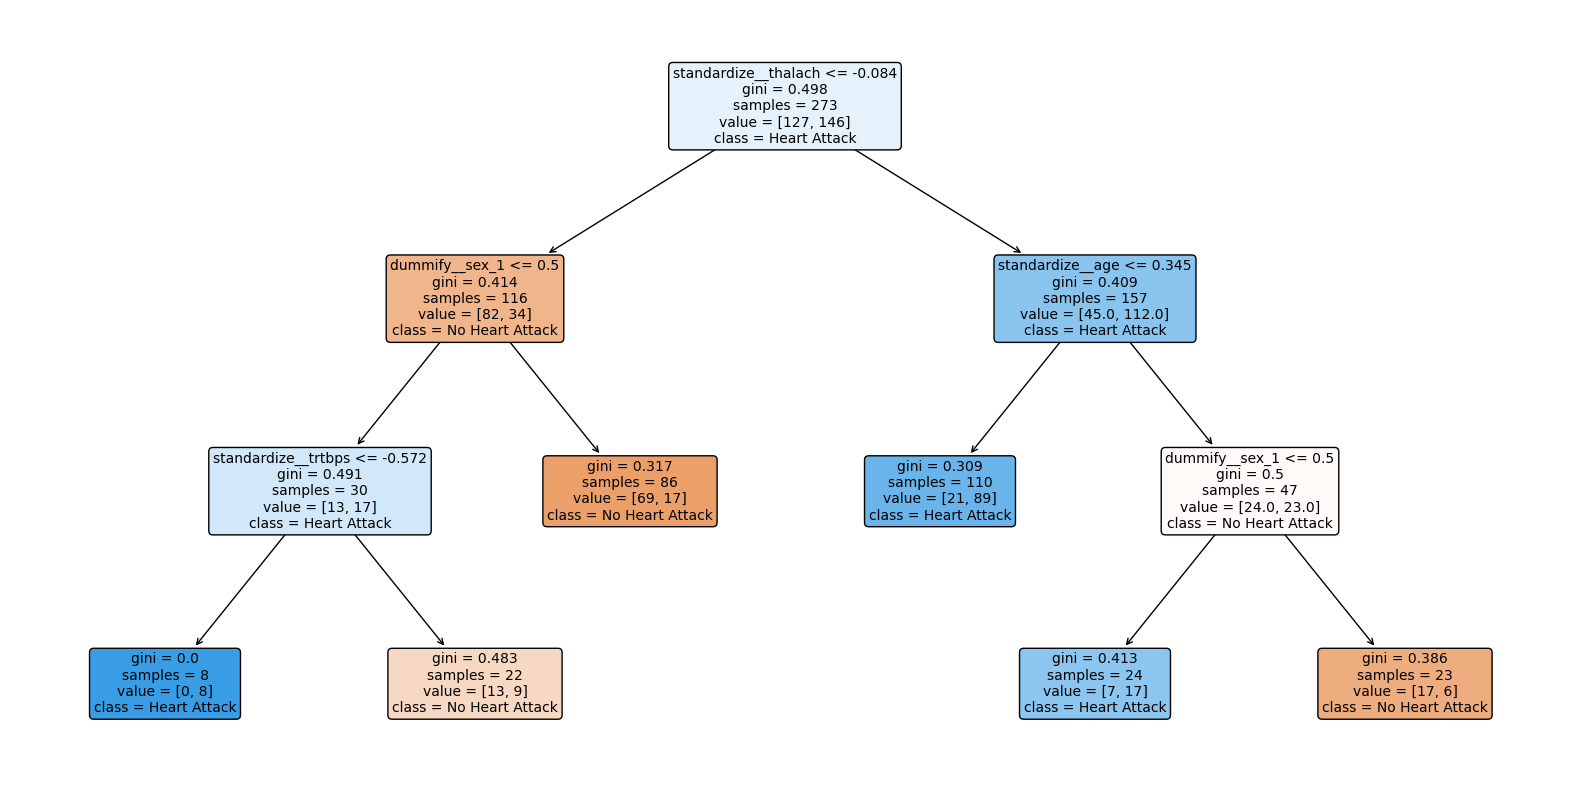

In [37]:
feature_names = dtree_grid_search.best_estimator_.named_steps['preprocessing'].get_feature_names_out()
best_decision_tree_model_plot = dtree_grid_search.best_estimator_.named_steps['dt']

# Used ChatGPT to Plot Decision tree 
plt.figure(figsize=(20, 10))
plot_tree(best_decision_tree_model_plot,
          feature_names=feature_names,
          class_names=["No Heart Attack", "Heart Attack"],
          filled=True,
          rounded=True,
          fontsize=10)
plt.show()

### Interpretation

In [32]:
log_reg_model = best_log_reg_model.named_steps['logistic']

log_reg_coefficients = log_reg_model.coef_[0]

feature_names = best_log_reg_model.named_steps['preprocessing'].get_feature_names_out()
log_reg_feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': log_reg_coefficients}).sort_values('Coefficient', ascending = False)
log_reg_feature_importance

,Feature,Coefficient
1,dummify__cp_1,1.819411
2,dummify__cp_2,1.740139
3,dummify__cp_3,1.439256
9,standardize__thalach,0.780818
4,dummify__restecg_1,0.341112
6,standardize__age,-0.218351
8,standardize__chol,-0.274967
7,standardize__trtbps,-0.310469
5,dummify__restecg_2,-0.321115
0,dummify__sex_1,-1.927438


In [34]:
decision_tree_model = best_dt_model.named_steps['dt']

decision_tree_importances = decision_tree_model.feature_importances_

decision_tree_feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': decision_tree_importances})
decision_tree_feature_importance

,Feature,Importance
0,dummify__sex_1,0.238282
1,dummify__cp_1,0.000000
2,dummify__cp_2,0.000000
3,dummify__cp_3,0.000000
4,dummify__restecg_1,0.000000
5,dummify__restecg_2,0.000000
6,standardize__age,0.149100
7,standardize__trtbps,0.090731
8,standardize__chol,0.000000
9,standardize__thalach,0.521888


The predictors most important to predicting heart attack risk in the logistic regression model are being male and having the chest pain type typical angina.

For the decision tree, the most significant predictors are maximum heart rate achieved during exercise and being male.

### ROC Curve

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 3)

probs_knn = best_knn_model.predict_proba(X_test)[:, 1]
probs_log_reg = best_log_reg_model.predict_proba(X_test)[:, 1]
probs_decision_tree = best_dt_model.predict_proba(X_test)[:, 1]

fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, probs_knn)
fpr_log_reg, tpr_log_reg, thresholds_log_reg = roc_curve(y_test, probs_log_reg)
fpr_decision_tree, tpr_decision_tree, thresholds_decision_tree = roc_curve(y_test, probs_decision_tree)

auc_knn = auc(fpr_knn, tpr_knn)
auc_log_reg = auc(fpr_log_reg, tpr_log_reg)
auc_decision_tree = auc(fpr_decision_tree, tpr_decision_tree)

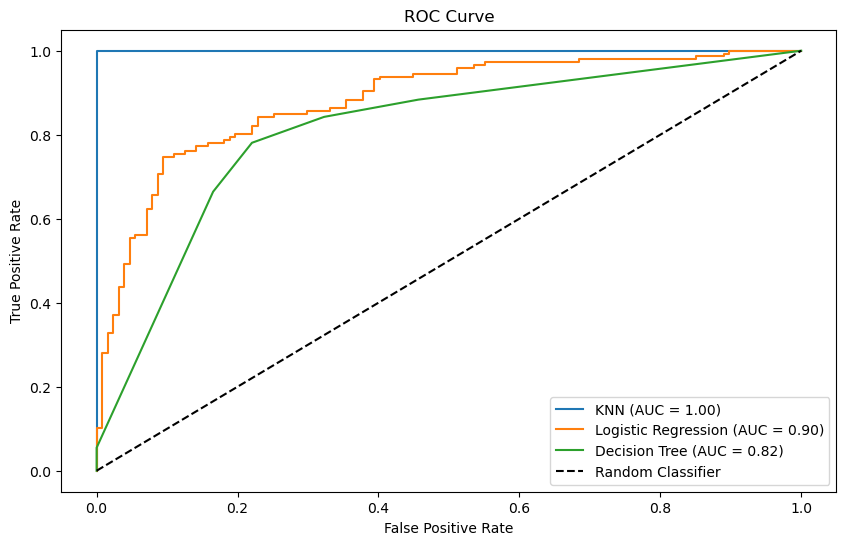

In [42]:
# Utilized ChatGPT to help me plot the ROC AUC Curve
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr_knn, tpr_knn, _ = roc_curve(y, y_proba_knn)
fpr_log_reg, tpr_log_reg, _ = roc_curve(y, y_proba_log_reg)
fpr_dt, tpr_dt, _ = roc_curve(y, y_proba_dt)

plt.figure(figsize=(10, 6))
plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {auc_knn:.2f})')
plt.plot(fpr_log_reg, tpr_log_reg, label=f'Logistic Regression (AUC = {auc_log_reg:.2f})')
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {auc_decision_tree:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

## Part Two: Metrics

In [47]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

# ChatGPT created this function to compute the Sensitivity, Precision, and Specificity
def compute_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    recall = tp / (tp + fn) 
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0 
    
    return {"Recall (Sensitivity)": recall, "Precision": precision, "Specificity": specificity}

# Cross-validated predictions
knn_preds = cross_val_predict(best_knn_model, X, y, cv=5)
log_reg_preds = cross_val_predict(best_log_reg_model, X, y, cv=5)
dt_preds = cross_val_predict(best_dt_model, X, y, cv=5)

# Compute metrics
knn_metrics = compute_metrics(y, knn_preds)
log_reg_metrics = compute_metrics(y, log_reg_preds)
dt_metrics = compute_metrics(y, dt_preds)

# Display results
print("KNN Metrics:", knn_metrics)
print("Logistic Regression Metrics:", log_reg_metrics)
print("Decision Tree Metrics:", dt_metrics)


KNN Metrics: {'Recall (Sensitivity)': 0.7123287671232876, 'Precision': 0.7819548872180451, 'Specificity': 0.7716535433070866}
Logistic Regression Metrics: {'Recall (Sensitivity)': 0.815068493150685, 'Precision': 0.7880794701986755, 'Specificity': 0.7480314960629921}
Decision Tree Metrics: {'Recall (Sensitivity)': 0.7328767123287672, 'Precision': 0.7482517482517482, 'Specificity': 0.7165354330708661}
KNN Metrics: {'Recall (Sensitivity)': 0.7123287671232876, 'Precision': 0.7819548872180451, 'Specificity': 0.7716535433070866}
Logistic Regression Metrics: {'Recall (Sensitivity)': 0.815068493150685, 'Precision': 0.7880794701986755, 'Specificity': 0.7480314960629921}
Decision Tree Metrics: {'Recall (Sensitivity)': 0.7328767123287672, 'Precision': 0.7482517482517482, 'Specificity': 0.7165354330708661}


## Part Three: Discussion

### Q1
#### The hospital faces severe lawsuits if they deem a patient to be low risk, and that patient later experiences a heart attack.



Sensitivity is the most important metric in this case because we need to minimize false negatives, which are cases where a patient at risk for a heart attack is incorrectly classified as low risk. The Logistic Regression model is the best choice because has the highest sensitivity out of the three models of 0.815. This means that approximately 81.5% of actual high-risk patients will be correctly identified.

### Q2
#### The hospital is overfull, and wants to only use bed space for patients most in need of monitoring due to heart attack risk.

Precision is the most important metric in this case because it ensures that the majority of patients flagged as high-risk truly are high-risk, which is essential for efficiently using limited resources. The Logistic Regression model is the best choice because has the highest precision out of the three models of 0.788. This means that approximately  about 78.8% of the patients identified as high risk are actually at risk.


### Q3
#### The hospital is studying root causes of heart attacks, and would like to understand which biological measures are associated with heart attack risk.

The focus here is on understanding relationships between features and heart attack risk, so model interpretability is key. I believe that Logistic Regression would be the best model in this case because it provides coefficients that can be interpreted easily to directly understand the relationship between each predictor and heart attack risk.


### Q4
#### The hospital is training a new batch of doctors, and they would like to compare the diagnoses of these doctors to the predictions given by the algorithm to measure the ability of new doctors to diagnose patients

In this case overall accuracy is most important. This ensures the model's classifications align closely with the actual outcomes, providing a benchmark for new doctors' performance. The Confusion Matrix offers a detailed breakdown of errors, which can help assess where doctors are overperforming or underperforming. I think that the KNN Model would be the best choice because it offers a simple, flexible benchmark. The KNN model had 0 False Negatives and 0 False Positives.

## Part Four: Validation

In [48]:
ha_validation = pd.read_csv("https://www.dropbox.com/s/jkwqdiyx6o6oad0/heart_attack_validation.csv?dl=1")

In [49]:
ha_validation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   age      30 non-null     int64
 1   sex      30 non-null     int64
 2   cp       30 non-null     int64
 3   trtbps   30 non-null     int64
 4   chol     30 non-null     int64
 5   restecg  30 non-null     int64
 6   thalach  30 non-null     int64
 7   output   30 non-null     int64
dtypes: int64(8)
memory usage: 2.0 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   age      30 non-null     int64
 1   sex      30 non-null     int64
 2   cp       30 non-null     int64
 3   trtbps   30 non-null     int64
 4   chol     30 non-null     int64
 5   restecg  30 non-null     int64
 6   thalach  30 non-null     int64
 7   output   30 non-null     int64
dtypes: int64(8)
memory usage: 2.0 KB


In [50]:
ha_validation['sex'] = ha_validation['sex'].astype('category')
ha_validation['cp'] = ha_validation['cp'].astype('category')
ha_validation['restecg'] = ha_validation['restecg'].astype('category')
ha_validation['output'] = ha_validation['output'].astype('category')

In [51]:
X_valid = ha_validation.drop("output", axis=1)
y_valid = ha_validation["output"]


### KNN Validation

In [53]:
knn_preds = best_knn_model.predict(X_valid)
knn_probs = best_knn_model.predict_proba(X_valid)[:, 1]

knn_confusion = confusion_matrix(y_valid, knn_preds)
knn_roc_auc = roc_auc_score(y_valid, knn_probs)
knn_precision = precision_score(y_valid, knn_preds)
knn_recall = recall_score(y_valid, knn_preds)

print("Confusion Matrix:\n", knn_confusion)
print("ROC AUC:", knn_roc_auc)
print("Precision:", knn_precision)
print("Recall:", knn_recall)


Confusion Matrix:
 [[10  1]
 [ 8 11]]
ROC AUC: 0.8516746411483254
Precision: 0.9166666666666666
Recall: 0.5789473684210527
Confusion Matrix:
 [[10  1]
 [ 8 11]]
ROC AUC: 0.8516746411483254
Precision: 0.9166666666666666
Recall: 0.5789473684210527


The ROC AUC score on the validation model is slightly higher, this means that our model had a good fit. Our actual precision score was much higher than our estimated precision score, but this came at the expense of the recall score which is significanly lower than our predicted value.

### Logisitic Regression Validation

In [57]:
log_preds = best_log_reg_model.predict(X_valid)
log_probs = best_log_reg_model.predict_proba(X_valid)[:, 1]

log_confusion = confusion_matrix(y_valid, log_preds)
log_roc_auc = roc_auc_score(y_valid, log_probs)
log_precision = precision_score(y_valid, log_preds)
log_recall = recall_score(y_valid, log_preds)

print("Confusion Matrix:\n", log_confusion)
print("ROC AUC:", log_roc_auc)
print("Precision:", log_precision)
print("Recall:", log_recall)

Confusion Matrix:
 [[ 8  3]
 [ 4 15]]
ROC AUC: 0.8803827751196172
Precision: 0.8333333333333334
Recall: 0.7894736842105263
Confusion Matrix:
 [[ 8  3]
 [ 4 15]]
ROC AUC: 0.8803827751196172
Precision: 0.8333333333333334
Recall: 0.7894736842105263


Agiain the ROC AUC score on the validation model is higher, meaning the fit of the Logistic Regression was good. Our actual precision score was a little higher than our estimated precision score, but this came at the expense of the recall score which is also slightly lower than our predicted value.

### Decision Tree Validation

In [58]:
dtree_preds = best_dt_model.predict(X_valid)
dtree_probs = best_dt_model.predict_proba(X_valid)[:, 1]

dtree_confusion = confusion_matrix(y_valid, dtree_preds)
dtree_roc_auc = roc_auc_score(y_valid, dtree_probs)
dtree_precision = precision_score(y_valid, dtree_preds)
dtree_recall = recall_score(y_valid, dtree_preds)

print("Confusion Matrix:\n", dtree_confusion)
print("ROC AUC:", dtree_roc_auc)
print("Precision:", dtree_precision)
print("Recall:", dtree_recall)

Confusion Matrix:
 [[ 9  2]
 [ 7 12]]
ROC AUC: 0.7822966507177033
Precision: 0.8571428571428571
Recall: 0.631578947368421
Confusion Matrix:
 [[ 9  2]
 [ 7 12]]
ROC AUC: 0.7822966507177033
Precision: 0.8571428571428571
Recall: 0.631578947368421


The ROC AUC score on the validation model is sligthly higher, so again this model has a good fit for the dataset. Again the actual precision score was higher than our estimated precision score, and caused the recall score to decrease by 0.1 from our predicted value.

## Part Five: Cohen’s Kappa


Cohen’s Kappa is a metric that measures the level of agreement between the predictions of a classifier and the true labels while accounting for chance agreement. It is particularly useful in cases of imbalanced data, where standard metrics like accuracy can be misleading.



### KNN

In [59]:
cohen_kappa_score(y_valid, knn_preds)

0.4303797468354431

This would be considered moderate agreement, suggesting an okay model.

### Logistic Regression

In [60]:
cohen_kappa_score(y_valid, log_preds)

0.5070422535211268

This would also be considered moderate agreement, suggesting an okay model.

### Decision Tree

In [61]:
cohen_kappa_score(y_valid, dtree_preds)

0.4104803493449781

Lastly this would also be considered moderate agreement, suggesting an okay model.

The model with the highest Cohen’s Kappa is the Logistic Regression Model, which is also the model that had the highest ROC AUC on the Validation data. So this metric reinforces the confidence in the Logistic Regression model choice. Cohen's Kappa is a valuable metric when an overall measure of model performance is needed without having to pick between either precision or recall. This is particularly useful in healthcare scenarios where both false positives and false negatives can have serious consequences. Our previous conclusions continue to favor logistic regression due to its highest Cohen's Kappa and ROC-AUC, as well as its interpretable coefficients.